# 1D Burgers equation on a periodic domain

The [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation) is a Partial Differential Equation (PDE) that describes convection and diffusion. It can also be viewed as a simplified version of the [Navier-Stokes equation](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations). Here, we start with the equation in the following form:

$\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=\nu \frac{\partial^2 u}{\partial x^2}$

on the domain $x \in [0, L]$ and $0 \le t \le T$. The domain is considered periodic in $x$. And the initial condition is given by:

$u(x,t=0) = 1.0 + 0.5 \cos(2\pi/L x)$ 



In [16]:
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Measures
using Plots
using JLD2

In [2]:
# define the model

"""
    Wave1DPeriodic_cpu

    A 1D wave equation with periodic boundary conditions.
    The state is represented as a ComponentArray with two fields:
    - h: height
    - u: velocity
"""
struct burgers_equation
    Δx::Float64 # grid spacing
    ν::Float64 # viscosity
    du_dx::Vector{Float64} # temporary storage for du/dx
    d2u_dx2::Vector{Float64} # temporary storage for d2u/dx2
end

function dx!(du, u, Δx) # upwind du_dx for u * du/dx term
    n = length(u)
    for i=2:n
        du[i] = (u[i] - u[i - 1]) / Δx
    end
    du[1] = (u[1] - u[end]) / Δx
end

function dx2!(du, u, Δx) # central second difference for ν d2u/dx2 term
    n = length(u)
    for i=2:n-1
        du[i] = (u[i + 1] - 2 * u[i] + u[i - 1]) / (Δx^2)
    end
    du[1] = (u[end] - 2 * u[1] + u[2]) / (Δx^2)
    du[end] = (u[end - 1] - 2 * u[end] + u[1]) / (Δx^2)
end

"""
# Define the function that computes the time derivative of the state
 du/dt = -u * du/dx + ν * d2u/dx2
"""
function (f::burgers_equation)(du_dt, u, p, t)
    Δx = f.Δx
    ν = f.ν
    du_dx = f.du_dx
    d2u_dx2 = f.d2u_dx2
    dx!(du_dx, u, Δx)
    dx2!(d2u_dx2, u, Δx)
    @. du_dt = -u * du_dx #+  ν*d2u_dx2 
    # The diffusion term is switched off because the first order upwind scheme is numerically diffusive
end

function burgers_initial_condition(x, k, u_mean=1.0, u_amplitude=0.5)
    return u_mean .+ u_amplitude .* cos.(k * x)
end



burgers_initial_condition (generic function with 3 methods)

In [3]:
# setting up the problem

# parameters
nx = 100     # number of spatial points
L = 10.0     # length of the domain
Δx = L / nx  # spatial step
ν = 0.1      # viscosity
k = 2 * pi / L   # wave number for initial condition
u_mean = 1.0 # mean velocity
u_amplitude = 0.5 # amplitude of the initial condition
p = ()       # parameters (not used in this case)

# spatial grid
x = Δx * (1:nx) # spatial grid points

# initial condition
u0 = burgers_initial_condition(x, k, u_mean, u_amplitude)

# initialize model struct
f = burgers_equation(Δx, ν, similar(u0), similar(u0))

# time span
t_end = 100.0


100.0

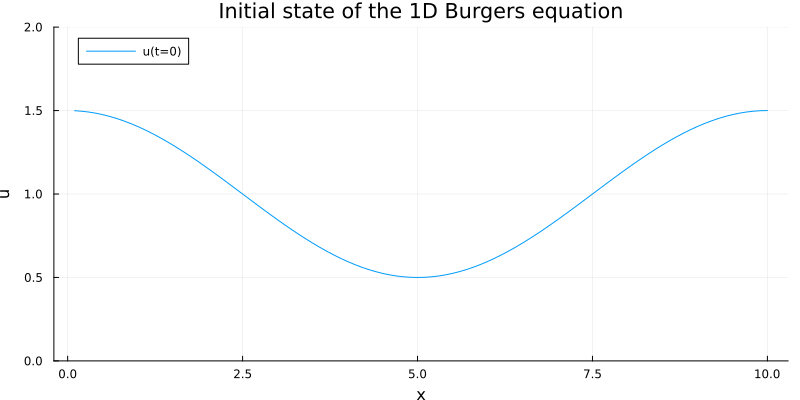

In [4]:
# plot the initial state
p1 = plot(x, u0, label = "u(t=0)", xlabel = "x", ylabel = "u")
plot(p1, size = (800,400), title = "Initial state of the 1D Burgers equation", ylim = (0, 2))

In [5]:
prob = ODEProblem(f, u0, (0.0, t_end))
@time sol = solve(prob, Tsit5(), saveat = 10.0) # with timing, but ouput only at t=10.0
sol = solve(prob, Tsit5()) # store output, no timing

nothing

  1.203482 seconds (4.35 M allocations: 224.913 MiB, 18.83% gc time, 99.52% compilation time)


┌ Info: Saved animation to /Users/sara/Desktop/Deltares/Julia/gpu/Final Report Code/Model-1/burgers1d_periodic.gif
└ @ Plots /Users/sara/.julia/packages/Plots/8ZnR3/src/animation.jl:156


 14.548053 seconds (5.72 M allocations: 302.687 MiB, 1.59% gc time, 5.26% compilation time: 20% of which was recompilation)


Plots.AnimatedGif("/Users/sara/Desktop/Deltares/Julia/gpu/Final Report Code/Model-1/burgers1d_periodic.gif")
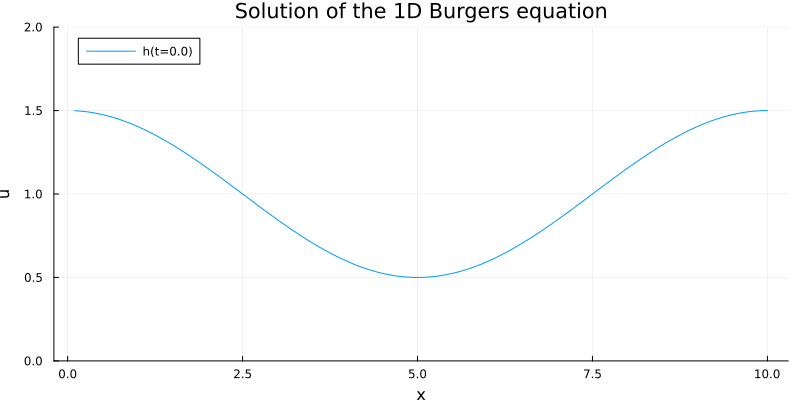

In [6]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(x, sol[i], label = "h(t=$(round(sol.t[i],digits=2)))", xlabel = "x", ylabel = "u", ylim = (0, 2))
        plot(p1, size = (800,400), title = "Solution of the 1D Burgers equation")
    end
    gif(anim, "burgers1d_periodic.gif", fps=15)
end


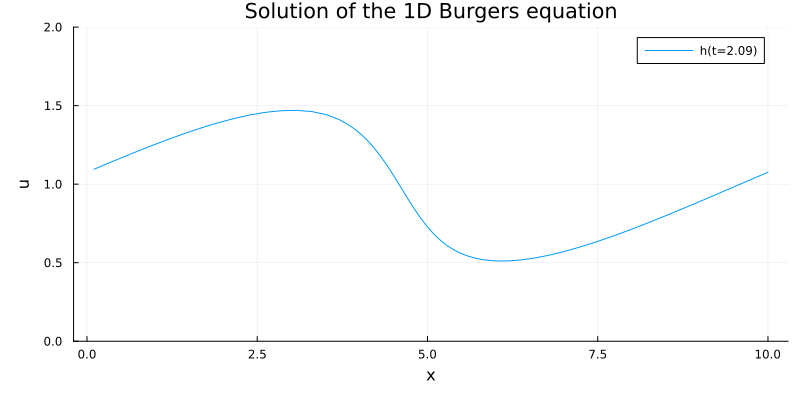

In [20]:
i = 10
p2 = plot(x, sol[i], label="h(t=$(round(sol.t[i],digits=2)))",xlabel="x", ylabel="u", ylim=(0,2))
plot!(p2, title="Solution of the 1D Burgers equation", size=(800,400), left_margin=6mm, bottom_margin=6mm)
savefig(p2, "burgers1d_periodic_final.png")
display(p2)

In [7]:
# save the solution to a JLD2 file
cfl_out = 1.0 # CFL number for output
dt_out = cfl_out * f.Δx / u_mean # time step for output, based on CFL condition
times = collect(0.0:dt_out:t_end) # output times
solution = []
for t in times
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("burgers1d_periodic.jld2", 
    "solution", solution,
    "times", times,
    "params", (ν = ν, Δx = Δx, u_mean = u_mean, u_amplitude = u_amplitude, k = k),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D Burgers equation with periodic boundary conditions, using a cosine as initial condition.")


In [8]:
# load the solution from the JLD2 file for testing
ff=load("burgers1d_periodic.jld2")

@show ff["solution"][1][1:20:end] # show some values of the initial velocity field

((ff["solution"])[1])[1:20:end] = [1.499013364214136, 1.1243449435824273, 0.5778360372489925, 0.6147433786121054, 1.1840622763423387]


5-element Vector{Float64}:
 1.499013364214136
 1.1243449435824273
 0.5778360372489925
 0.6147433786121054
 1.1840622763423387